# Waymo Open Dataset 3D Camera-Only Detection Tutorial

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset
- Challenge: https://waymo.com/intl/en_us/open/challenges/2022/3d-camera-only-detection/

This tutorial demonstrates how to interpret the camera-synced labels. Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

To use, open this notebook in [Colab](https://colab.research.google.com).

Uncheck the box "Reset all runtimes before running" if you run this colab directly from the remote kernel. Alternatively, you can make a copy before trying to run it by following "File > Save copy in Drive ...".



# Package Installation

To run the colab against dataset files stored on the local machine, we recommend launching a local runtime in your python environment with `waymo-open-dataset` installed. Please follow the instructions [here](https://research.google.com/colaboratory/local-runtimes.html).

Otherwise, you can follow the instructions in [tutorial.ipynb](https://github.com/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial.ipynb). Please pip install `waymo-open-dataset-tf-2-12-0==1.6.4` later than `1.4.6` and upload required segments to colab with any method in [io.ipynb](https://colab.research.google.com/notebooks/io.ipynb). Note that the upload could take a while due to large file sizes.

# Imports and Global Definitions

In [2]:
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import tensorflow as tf

if not tf.executing_eagerly():
  tf.compat.v1.enable_eager_execution()

from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset import label_pb2
# from waymo_open_dataset.camera.ops import py_camera_model_ops
from waymo_open_dataset.wdl_limited.camera.ops import py_camera_model_ops
from waymo_open_dataset.metrics.ops import py_metrics_ops
from waymo_open_dataset.metrics.python import config_util_py as config_util
from waymo_open_dataset.protos import breakdown_pb2
from waymo_open_dataset.protos import metrics_pb2
from waymo_open_dataset.protos import submission_pb2
from waymo_open_dataset.utils import box_utils

In [10]:
# Data location - please edit. Should point to a tfrecord containing tf.Example
# protos as downloaded from the Waymo Open Dataset website.

FILENAME = '/teamspace/studios/this_studio/waymo-open-dataset/waymo_open_dataset_v_1_4_3/individual_files/training/segment-16102220208346880_1420_000_1440_000_with_camera_labels.tfrecord'

# Read Frame

In [11]:
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
dataset_iter = dataset.as_numpy_iterator()

2025-04-13 05:50:28.609694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [12]:
# Get a frame from the segment. Run this cell again to obtain next frame.
data = next(dataset_iter)
frame = open_dataset.Frame()
frame.ParseFromString(data)
print(frame.context.name, frame.timestamp_micros)

FILTER_AVAILABLE = any(
    [label.num_top_lidar_points_in_box > 0 for label in frame.laser_labels])

if not FILTER_AVAILABLE:
  print('WARNING: num_top_lidar_points_in_box does not seem to be populated. '
        'Make sure that you are using an up-to-date release (V1.3.2 or later) '
        'to enable improved filtering of occluded objects.')

16102220208346880_1420_000_1440_000 1554232885158113


# Visualize Camera Images

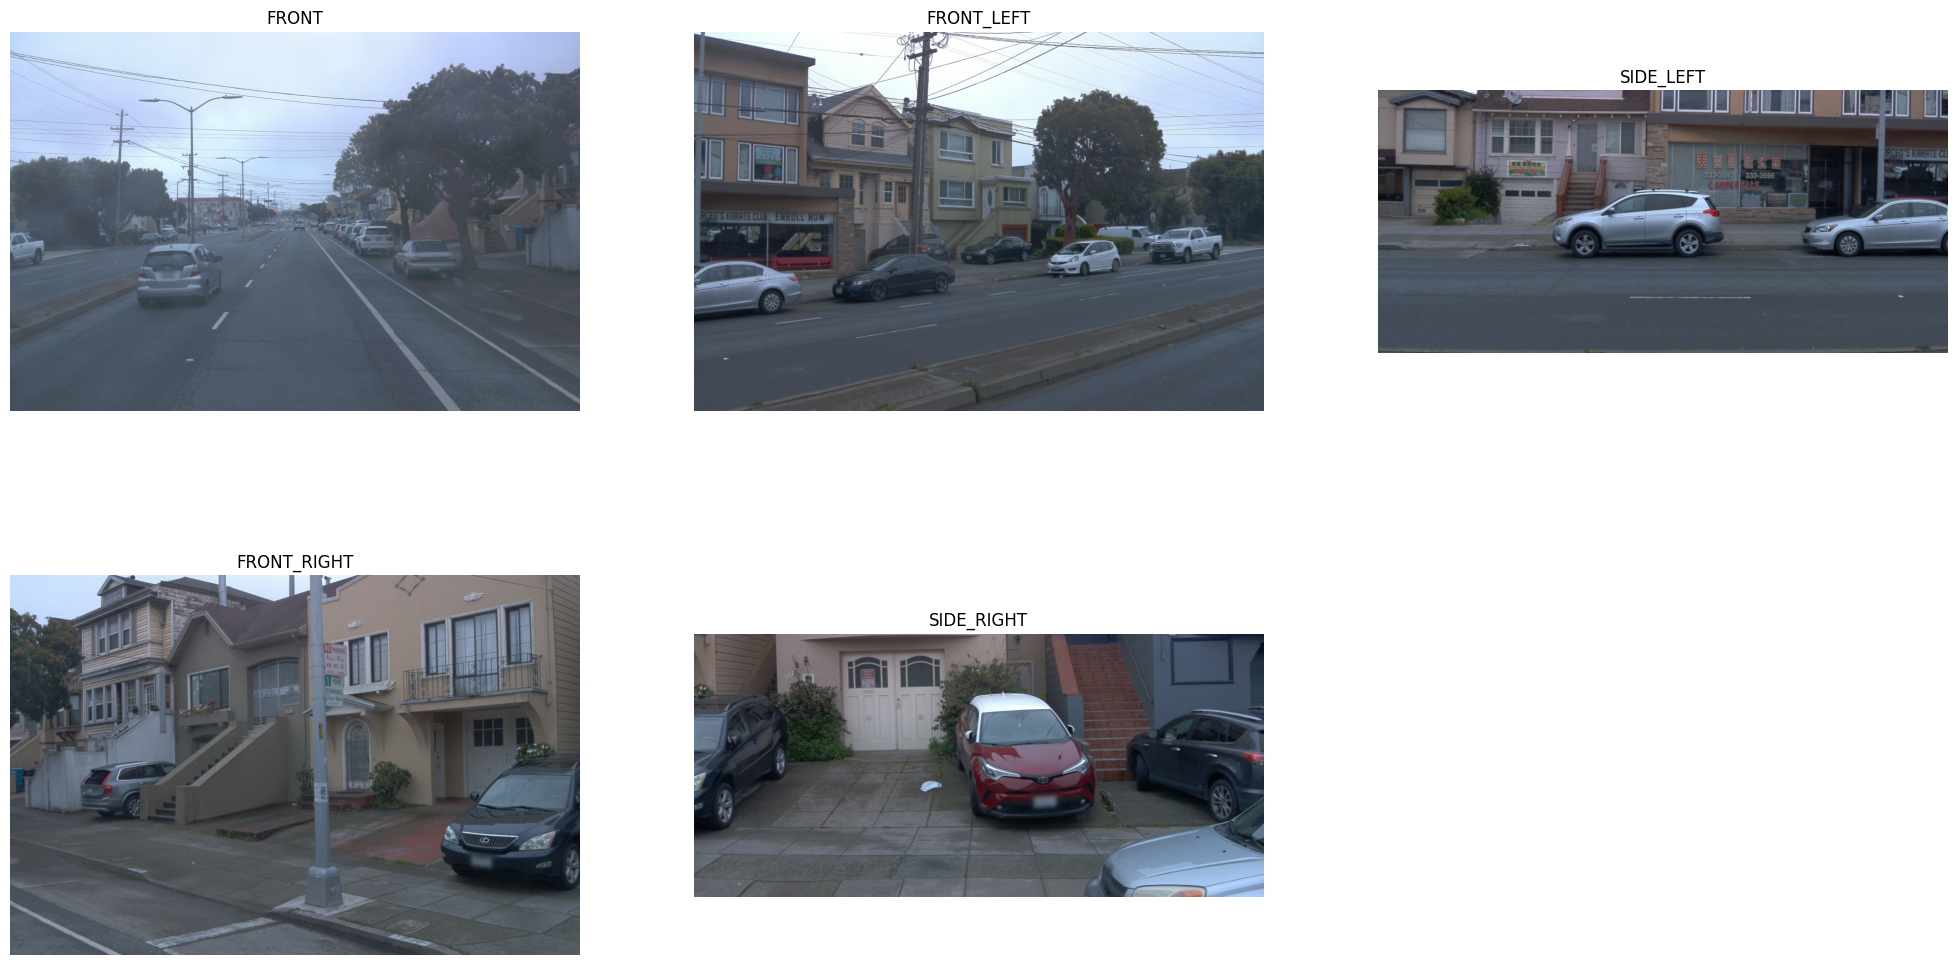

In [13]:
def show_camera_image(camera_image, layout):
  """Display the given camera image."""
  ax = plt.subplot(*layout)
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
  plt.grid(False)
  plt.axis('off')
  return ax


plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  _ = show_camera_image(image, [3, 3, index + 1])

# Inspect 3D Labels

In addition to the original LiDAR-synced boxes (`box`), there are now camera-synced boxes (`camera_synced_box`) available, which can be useful for camera-centric modeling. Camera-synced boxes are designed to more accurately reflect the state of objects when they were observed by the camera, which is different from the time they were observed by our LiDAR sensors. During the time period between the sensors' respective captures of different parts of the surrounding environment, both the autonomously driven vehicle (ADV) and dynamic objects move, which is reflected by these boxes having slightly different positions.

Note that camera-synced boxes are only populated for boxes that are visible in at least one camera. Every camera-synced box also has a LiDAR-synced box equivalent, but not vice versa. This is the case because the cameras collectively only span a horizontal field of view of ~230 degrees.

In [14]:
lidar_synced_boxes = [lbl.box for lbl in frame.laser_labels]
camera_synced_boxes = [
    lbl.camera_synced_box
    for lbl in frame.laser_labels
    if lbl.camera_synced_box.ByteSize()
]
print(
    'Frame contains %s LiDAR-synced boxes, of which %s also have a camera-synced box equivalent.'
    % (len(lidar_synced_boxes), len(camera_synced_boxes)))

Frame contains 54 LiDAR-synced boxes, of which 29 also have a camera-synced box equivalent.


Along with their camera-synced box, we also provide `most_visible_camera`, the name of the camera where the object is most visible in.

In [15]:
for lbl in frame.laser_labels:
  if not lbl.camera_synced_box.ByteSize():
    continue

  offset = np.linalg.norm((lbl.box.center_x - lbl.camera_synced_box.center_x,
                           lbl.box.center_y - lbl.camera_synced_box.center_y,
                           lbl.box.center_z - lbl.camera_synced_box.center_z))
  print(
      'Label %s has an offset of %sm between box and camera_synced_box, and is most visible in camera %s.'
      % (lbl.id, round(offset, 3), lbl.most_visible_camera_name))

Label 0SFH7-2lVoK6DO8ys_Bk6Q has an offset of 0.016m between box and camera_synced_box, and is most visible in camera FRONT.
Label 3S1Jzdq9a6Jqyhdf8cuKzA has an offset of 0.071m between box and camera_synced_box, and is most visible in camera FRONT.
Label 4RZqXyhhBsKmX-9BzLywsw has an offset of 0.015m between box and camera_synced_box, and is most visible in camera FRONT.
Label 4oTaIeDdj5Jht50Omg_7QA has an offset of 0.057m between box and camera_synced_box, and is most visible in camera FRONT_LEFT.
Label 6512DZ9YY2i7E6MuZls9fg has an offset of 0.178m between box and camera_synced_box, and is most visible in camera FRONT.
Label AJKm0wC-jhpBDirlUBblqQ has an offset of 0.008m between box and camera_synced_box, and is most visible in camera FRONT_LEFT.
Label Bbcpd4CoYTzIIUwC1vXyRg has an offset of 0.12m between box and camera_synced_box, and is most visible in camera FRONT.
Label DFBcfkHMiZLHfQZ08ev16w has an offset of 0.194m between box and camera_synced_box, and is most visible in camer

## Visualize projected_lidar_labels

Here, we visualize `projected_lidar_labels`, which contains pre-projected 2D bounding boxes of all laser labels into all available camera images.

Note that unlike `camera_labels`, which are only associated with the corresponding `laser_labels` for certain object types, there is always a correspondence between `projected_lidar_labels` and `laser_labels`.

In [16]:
def show_projected_lidar_labels(camera_image, ax):
  """Displays pre-projected 3D laser labels."""

  for projected_labels in frame.projected_lidar_labels:
    # Ignore camera labels that do not correspond to this camera.
    if projected_labels.name != camera_image.name:
      continue

    # Iterate over the individual labels.
    for label in projected_labels.labels:
      # Draw the bounding box.
      rect = patches.Rectangle(
          xy=(label.box.center_x - 0.5 * label.box.length,
              label.box.center_y - 0.5 * label.box.width),
          width=label.box.length,
          height=label.box.width,
          linewidth=1,
          edgecolor=(0.0, 1.0, 0.0, 1.0),  # green
          facecolor=(0.0, 1.0, 0.0, 0.1))  # opaque green
      ax.add_patch(rect)

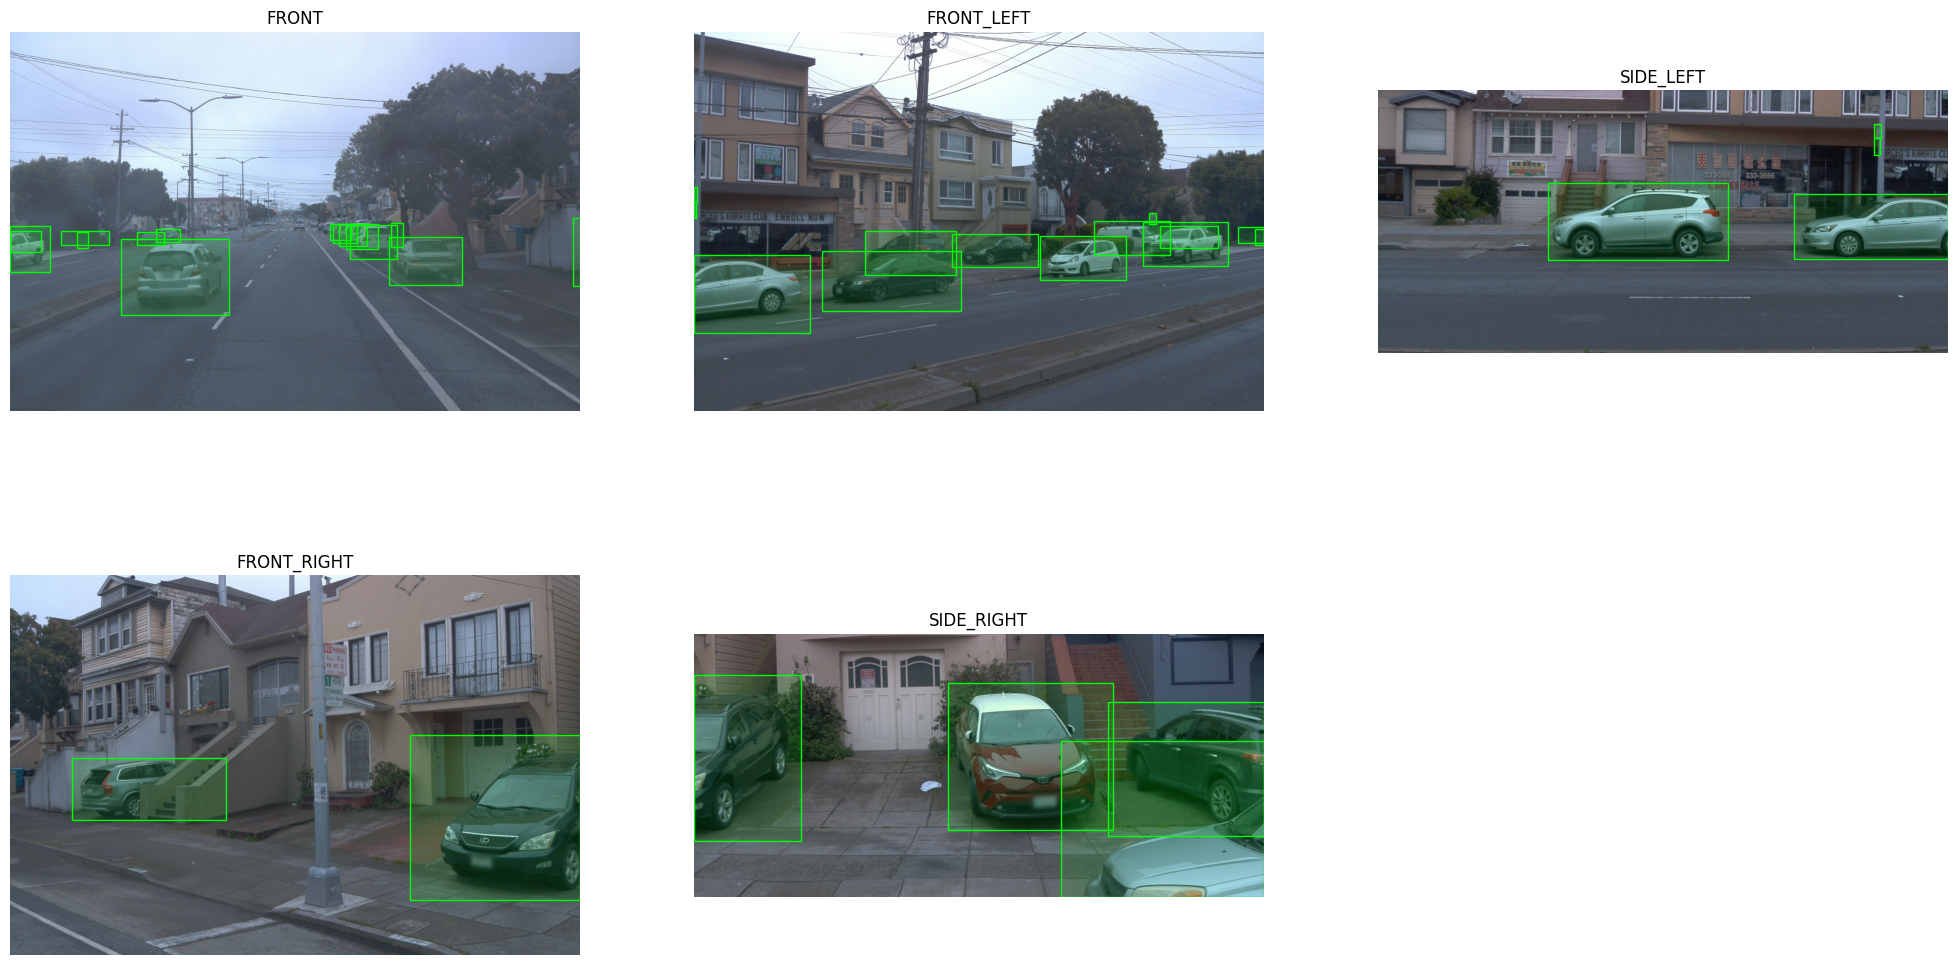

In [17]:
plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  ax = show_camera_image(image, [3, 3, index + 1])
  show_projected_lidar_labels(image, ax)

plt.show()

## Visualize camera_synced_box Projections

Here, we visualize projections of `camera_synced_box` onto the camera images. While the cameras have a rolling shutter, we use a global shutter projection, since rolling shutter effects were already factored in when creating the `camera_synced_box` labels.

In [18]:
def draw_2d_box(ax, u, v, color, linewidth=1):
  """Draws 2D bounding boxes as rectangles onto the given axis."""
  rect = patches.Rectangle(
      xy=(u.min(), v.min()),
      width=u.max() - u.min(),
      height=v.max() - v.min(),
      linewidth=linewidth,
      edgecolor=color,
      facecolor=list(color) + [0.1])  # Add alpha for opacity
  ax.add_patch(rect)


def draw_3d_wireframe_box(ax, u, v, color, linewidth=3):
  """Draws 3D wireframe bounding boxes onto the given axis."""
  # List of lines to interconnect. Allows for various forms of connectivity.
  # Four lines each describe bottom face, top face and vertical connectors.
  lines = ((0, 1), (1, 2), (2, 3), (3, 0), (4, 5), (5, 6), (6, 7), (7, 4),
           (0, 4), (1, 5), (2, 6), (3, 7))

  for (point_idx1, point_idx2) in lines:
    line = plt.Line2D(
        xdata=(int(u[point_idx1]), int(u[point_idx2])),
        ydata=(int(v[point_idx1]), int(v[point_idx2])),
        linewidth=linewidth,
        color=list(color) + [0.5])  # Add alpha for opacity
    ax.add_line(line)

In [19]:
def project_vehicle_to_image(vehicle_pose, calibration, points):
  """Projects from vehicle coordinate system to image with global shutter.

  Arguments:
    vehicle_pose: Vehicle pose transform from vehicle into world coordinate
      system.
    calibration: Camera calibration details (including intrinsics/extrinsics).
    points: Points to project of shape [N, 3] in vehicle coordinate system.

  Returns:
    Array of shape [N, 3], with the latter dimension composed of (u, v, ok).
  """
  # Transform points from vehicle to world coordinate system (can be
  # vectorized).
  pose_matrix = np.array(vehicle_pose.transform).reshape(4, 4)
  world_points = np.zeros_like(points)
  for i, point in enumerate(points):
    cx, cy, cz, _ = np.matmul(pose_matrix, [*point, 1])
    world_points[i] = (cx, cy, cz)

  # Populate camera image metadata. Velocity and latency stats are filled with
  # zeroes.
  extrinsic = tf.reshape(
      tf.constant(list(calibration.extrinsic.transform), dtype=tf.float32),
      [4, 4])
  intrinsic = tf.constant(list(calibration.intrinsic), dtype=tf.float32)
  metadata = tf.constant([
      calibration.width,
      calibration.height,
      open_dataset.CameraCalibration.GLOBAL_SHUTTER,
  ],
                         dtype=tf.int32)
  camera_image_metadata = list(vehicle_pose.transform) + [0.0] * 10

  # Perform projection and return projected image coordinates (u, v, ok).
  return py_camera_model_ops.world_to_image(extrinsic, intrinsic, metadata,
                                            camera_image_metadata,
                                            world_points).numpy()

In [20]:
def show_projected_camera_synced_boxes(camera_image, ax, draw_3d_box=False):
  """Displays camera_synced_box 3D labels projected onto camera."""
  # Fetch matching camera calibration.
  calibration = next(cc for cc in frame.context.camera_calibrations
                     if cc.name == camera_image.name)

  for label in frame.laser_labels:
    box = label.camera_synced_box

    if not box.ByteSize():
      continue  # Filter out labels that do not have a camera_synced_box.
    if (FILTER_AVAILABLE and not label.num_top_lidar_points_in_box) or (
        not FILTER_AVAILABLE and not label.num_lidar_points_in_box):
      continue  # Filter out likely occluded objects.

    # Retrieve upright 3D box corners.
    box_coords = np.array([[
        box.center_x, box.center_y, box.center_z, box.length, box.width,
        box.height, box.heading
    ]])
    corners = box_utils.get_upright_3d_box_corners(
        box_coords)[0].numpy()  # [8, 3]

    # Project box corners from vehicle coordinates onto the image.
    projected_corners = project_vehicle_to_image(frame.pose, calibration,
                                                 corners)
    u, v, ok = projected_corners.transpose()
    ok = ok.astype(bool)

    # Skip object if any corner projection failed. Note that this is very
    # strict and can lead to exclusion of some partially visible objects.
    if not all(ok):
      continue
    u = u[ok]
    v = v[ok]

    # Clip box to image bounds.
    u = np.clip(u, 0, calibration.width)
    v = np.clip(v, 0, calibration.height)

    if u.max() - u.min() == 0 or v.max() - v.min() == 0:
      continue

    if draw_3d_box:
      # Draw approximate 3D wireframe box onto the image. Occlusions are not
      # handled properly.
      draw_3d_wireframe_box(ax, u, v, (1.0, 1.0, 0.0))
    else:
      # Draw projected 2D box onto the image.
      draw_2d_box(ax, u, v, (1.0, 1.0, 0.0))

### 3D Wireframe Boxes

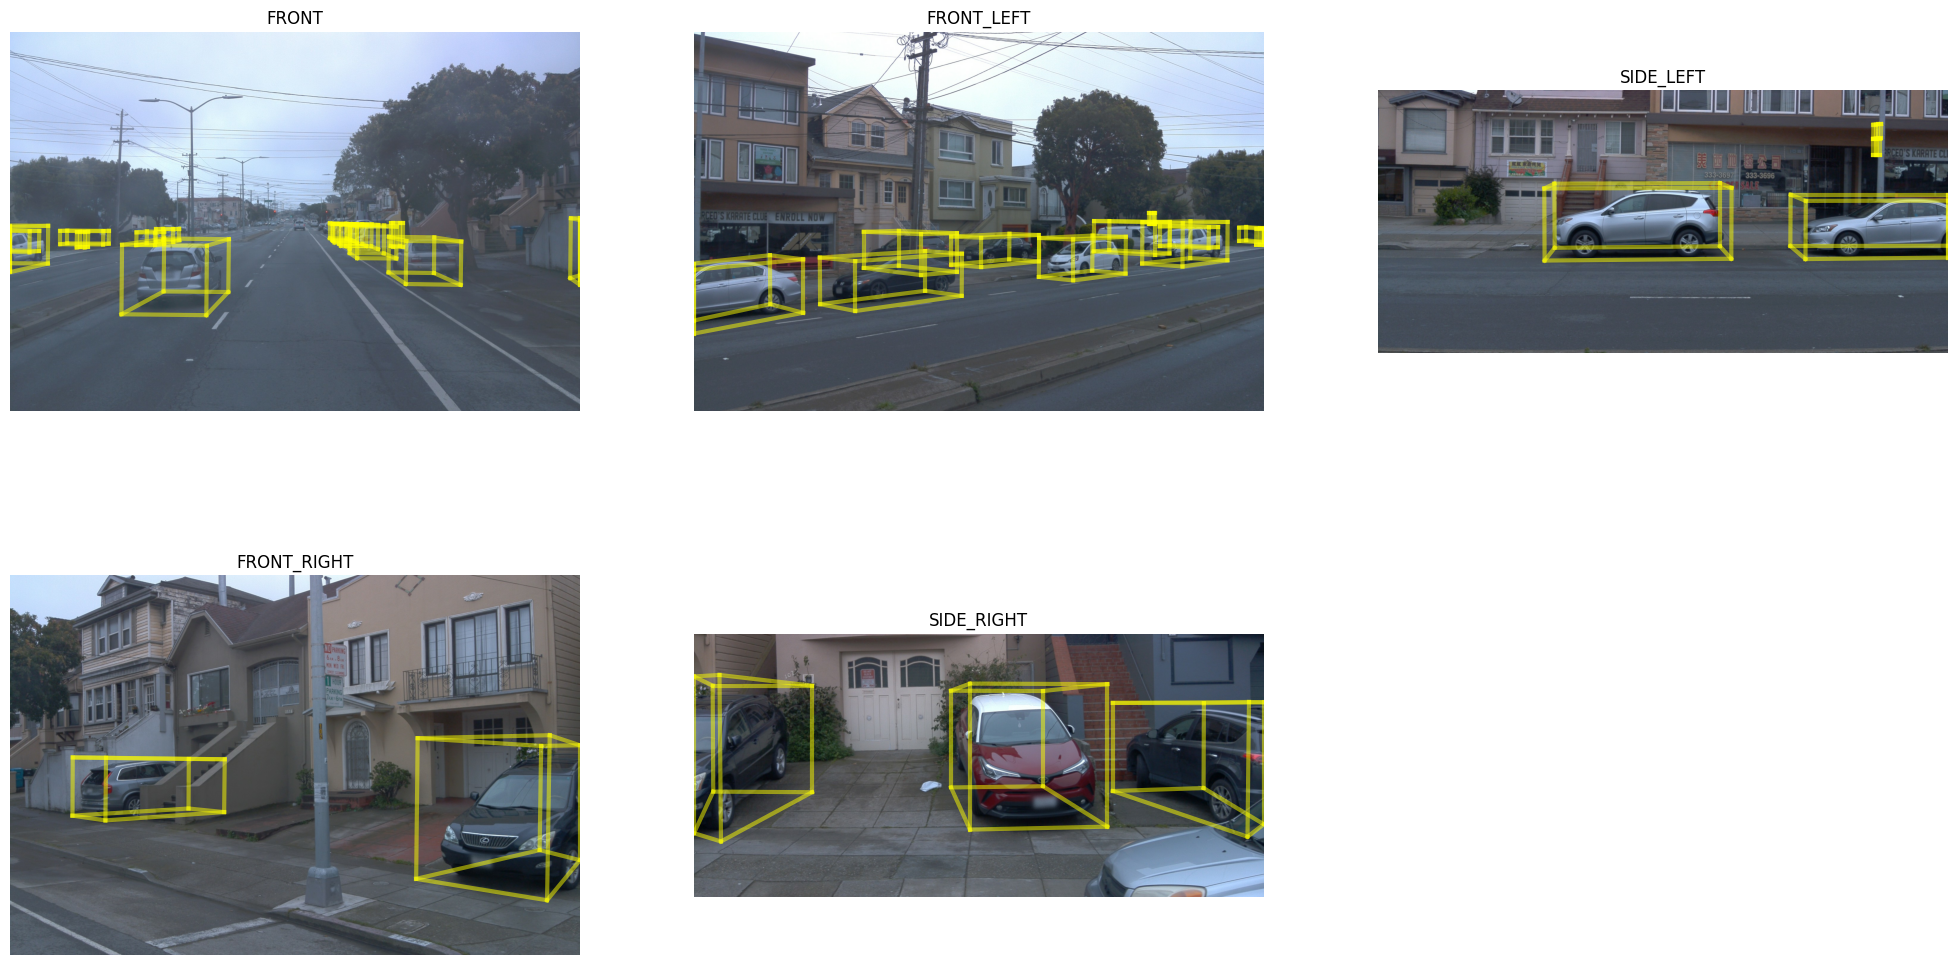

In [21]:
plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  ax = show_camera_image(image, [3, 3, index + 1])
  show_projected_camera_synced_boxes(image, ax, draw_3d_box=True)

plt.show()

### 2D Boxes

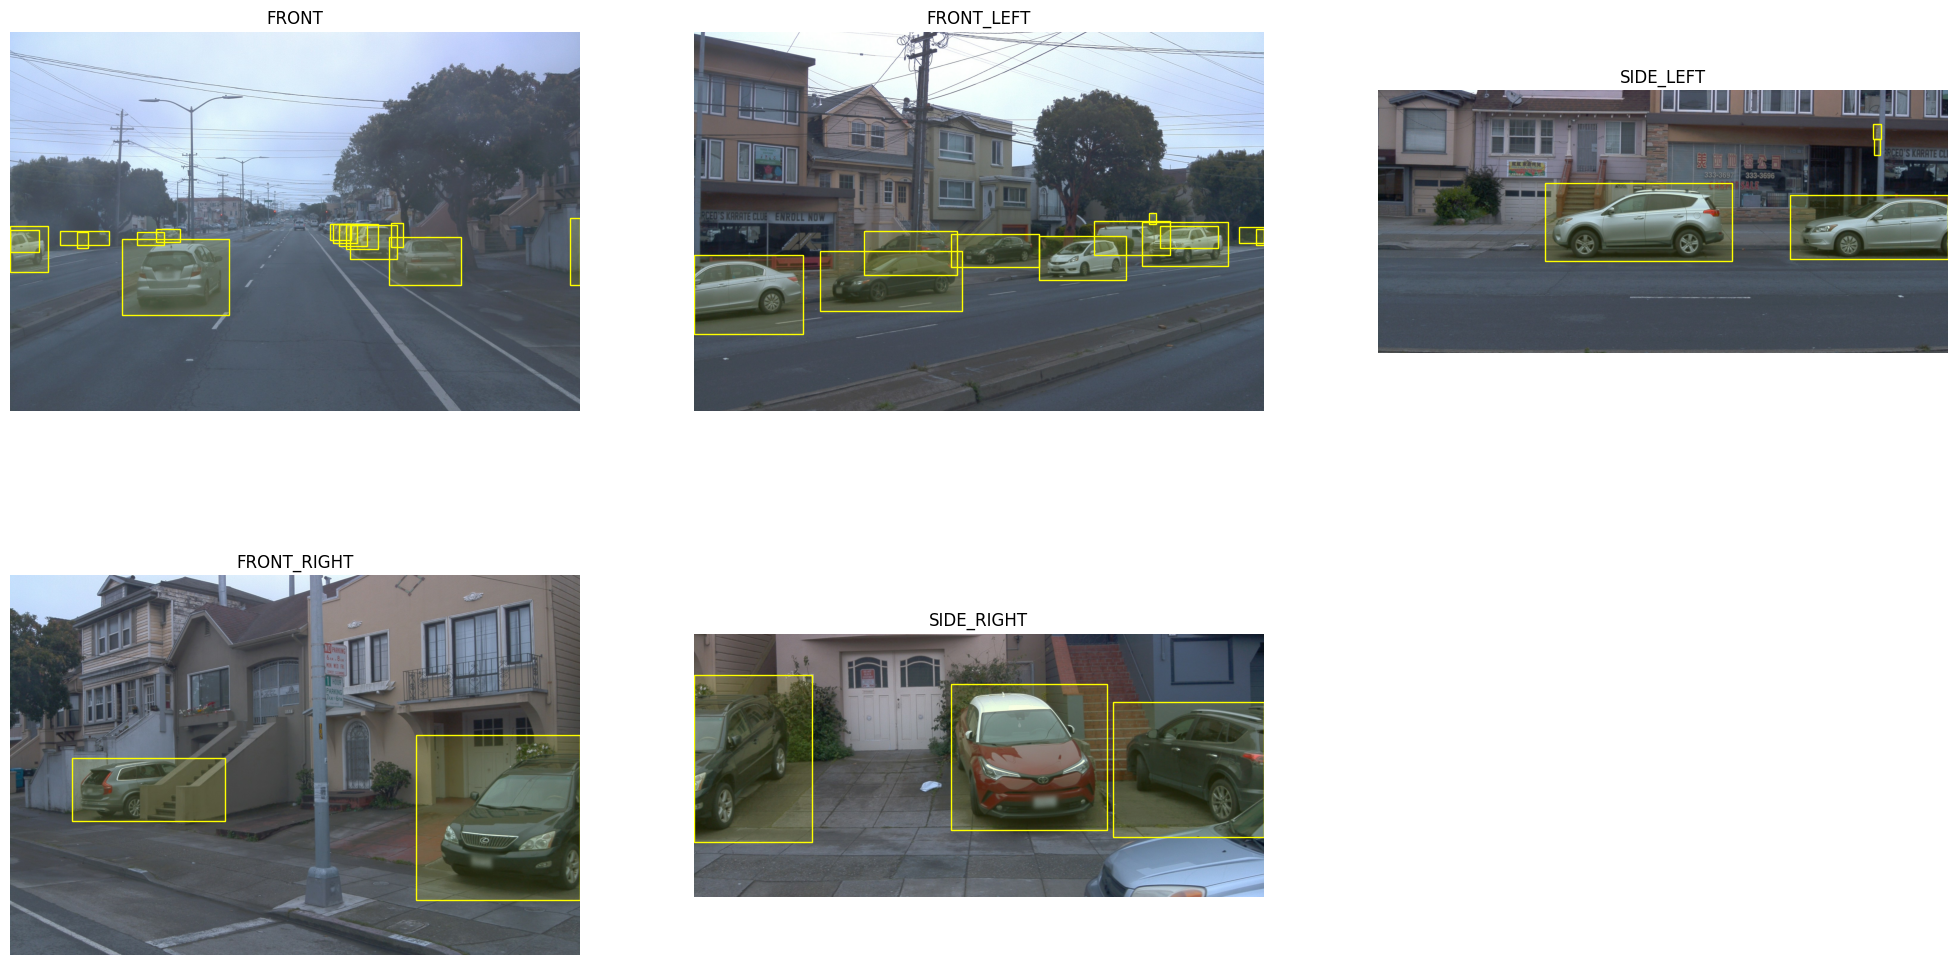

In [22]:
plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  ax = show_camera_image(image, [3, 3, index + 1])
  show_projected_camera_synced_boxes(image, ax, draw_3d_box=False)

plt.show()

## Comparison

This visualization compares `projected_lidar_labels` (green) with our global-shutter projection of `camera_synced_box` (yellow). The results are similar, but some discrepancies can be observed. This is due to the fact that `projected_lidar_labels` are based on rolling shutter-projected LiDAR-synced `box` labels.

We recommend using the already provided `projected_lidar_labels` if corresponding 2D boxes are needed.

For more details, please also refer to the [challenge webpage](https://waymo.com/intl/en_us/open/challenges/2022/3d-camera-only-detection/).

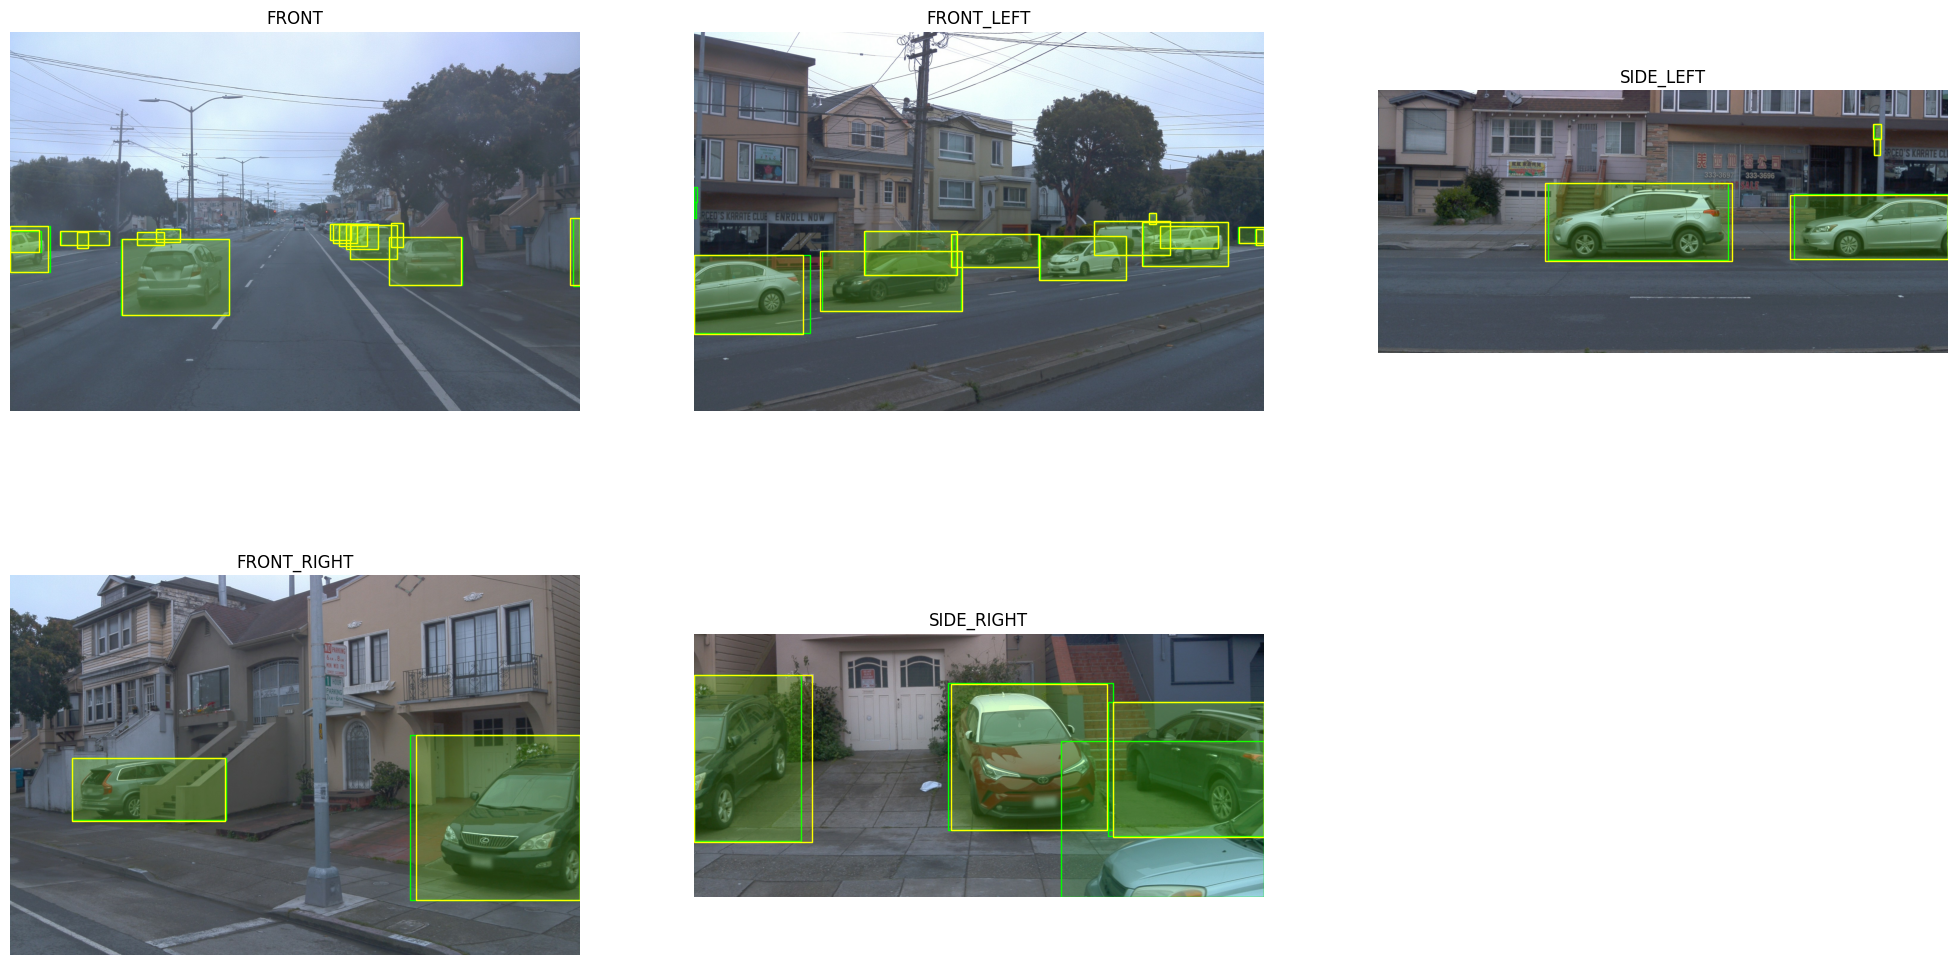

In [23]:
plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  ax = show_camera_image(image, [3, 3, index + 1])
  show_projected_lidar_labels(image, ax)
  show_projected_camera_synced_boxes(image, ax, draw_3d_box=False)

plt.show()

# Create Submission

To participate in the challenge, a submission file containing predictions for the validation or test set must be assembled and submitted to the [challenge website](https://waymo.com/intl/en_us/open/challenges/2022/3d-camera-only-detection/). The evaluation server will compute detailed metrics and add them to the leaderboard.

The cells below exemplify how to create a submission file.

In [ ]:
def make_inference_objects(context_name, timestamp, boxes, classes, scores):
  """Create objects based on inference results of a frame.

  Args:
    context_name: The context name of the segment.
    timestamp: The timestamp of the frame.
    boxes: A [N, 7] float numpy array that describe the inferences boxes of the
      frame, assuming each row is of the form [center_x, center_y, center_z,
      length, width, height, heading].
    classes: A [N] numpy array that describe the inferences classes. See
      label_pb2.Label.Type for the class values. TYPE_VEHICLE = 1;
      TYPE_PEDESTRIAN = 2; TYPE_SIGN = 3; TYPE_CYCLIST = 4;
    scores: A [N] float numpy array that describe the detection scores.

  Returns:
    A list of metrics_pb2.Object.
  """
  objects = []
  for i in range(boxes.shape[0]):
    x, y, z, l, w, h, heading = boxes[i]
    cls = classes[i]
    score = scores[i]
    objects.append(
        metrics_pb2.Object(
            object=label_pb2.Label(
                box=label_pb2.Label.Box(
                    center_x=x,
                    center_y=y,
                    center_z=z,
                    length=l,
                    width=w,
                    height=h,
                    heading=heading),
                type=label_pb2.Label.Type.Name(cls),
                id=f'{cls}_{i}'),
            score=score,
            context_name=context_name,
            frame_timestamp_micros=timestamp))
  return objects

In [ ]:
# Prepare predictions. Please modify accordingly to process your inference results.
context_names = ['1305342127382455702_3720_000_3740_000']

frame_timestamps = {
    # Please make sure that the timestamps match frame.timestamp_micros.
    '1305342127382455702_3720_000_3740_000': [1511019682029265, 1511019682129243]
}

prediction_objects = {}
for context_name in context_names:
  prediction_objects[context_name] = {}
  for timestamp in frame_timestamps[context_name]:
    # Create objects based on inference results
    prediction_objects[context_name][timestamp] = make_inference_objects(
        context_name=context_name,
        timestamp=timestamp,
        boxes=np.random.rand(3, 7),
        classes=np.random.randint(low=1, high=4, size=(3,)),
        scores=np.random.rand(3,))

In [ ]:
context_name = context_names[0]
timestamp = frame_timestamps[context_name][0]
print(prediction_objects[context_name][timestamp][0])

In [ ]:
# Pack to submission.
num_submission_shards = 4  # Please modify accordingly.
submission_file_base = '/tmp/MySubmission'  # Please modify accordingly.

if not os.path.exists(submission_file_base):
  os.makedirs(submission_file_base)
sub_file_names = [
    os.path.join(submission_file_base, part)
    for part in [f'part{i}' for i in range(num_submission_shards)]
]

submissions = [
    submission_pb2.Submission(inference_results=metrics_pb2.Objects())
    for i in range(num_submission_shards)
]

obj_counter = 0
for c_name, frames in prediction_objects.items():
  for timestamp, objects in frames.items():
    for obj in objects:
      submissions[obj_counter %
                  num_submission_shards].inference_results.objects.append(obj)
      obj_counter += 1

for i, shard in enumerate(submissions):
  shard.task = submission_pb2.Submission.CAMERA_ONLY_DETECTION_3D
  shard.authors[:] = ['A', 'B']  # Please modify accordingly.
  shard.affiliation = 'Affiliation'  # Please modify accordingly.
  shard.account_name = 'acc@domain.com'  # Please modify accordingly.
  shard.unique_method_name = 'YourMethodName'  # Please modify accordingly.
  shard.method_link = 'method_link'  # Please modify accordingly.
  shard.description = ''  # Please modify accordingly.
  shard.sensor_type = submission_pb2.Submission.CAMERA_ALL
  shard.number_past_frames_exclude_current = 0  # Please modify accordingly.
  shard.object_types[:] = [
      label_pb2.Label.TYPE_VEHICLE, label_pb2.Label.TYPE_PEDESTRIAN,
      label_pb2.Label.TYPE_CYCLIST
  ]
  with tf.io.gfile.GFile(sub_file_names[i], 'wb') as fp:
    fp.write(shard.SerializeToString())

In [ ]:
print(submissions[0])

## Package submission
```
cd /tmp
tar cvf MySubmission.tar MySubmission
gzip MySubmission.tar
```
Then you can upload `/tmp/MySubmission.tar.gz` to the challenge website.


# Compute Metrics

We provide `metrics/tools/compute_detection_let_metrics_main` as a binary tool.
Here, we provide a python example code for calculating LET metrics.

In [ ]:
def build_let_metrics_config():
  let_metric_config = metrics_pb2.Config.LongitudinalErrorTolerantConfig(
      enabled=True,
      sensor_location=metrics_pb2.Config.LongitudinalErrorTolerantConfig
      .Location3D(x=1.43, y=0, z=2.18),
      longitudinal_tolerance_percentage=0.1,  # 10% tolerance.
      min_longitudinal_tolerance_meter=0.5,
  )
  config = metrics_pb2.Config(
      box_type=label_pb2.Label.Box.TYPE_3D,
      matcher_type=metrics_pb2.MatcherProto.TYPE_HUNGARIAN,
      iou_thresholds=[0.0, 0.3, 0.5, 0.5, 0.5],
      score_cutoffs=[i * 0.01 for i in range(100)] + [1.0],
      let_metric_config=let_metric_config)

  config.breakdown_generator_ids.append(breakdown_pb2.Breakdown.OBJECT_TYPE)
  config.difficulties.append(
      metrics_pb2.Difficulty(levels=[label_pb2.Label.LEVEL_2]))
  config.breakdown_generator_ids.append(breakdown_pb2.Breakdown.CAMERA)
  config.difficulties.append(
      metrics_pb2.Difficulty(levels=[label_pb2.Label.LEVEL_2]))
  config.breakdown_generator_ids.append(breakdown_pb2.Breakdown.RANGE)
  config.difficulties.append(
      metrics_pb2.Difficulty(levels=[label_pb2.Label.LEVEL_2]))
  return config


def compute_let_detection_metrics(prediction_frame_id,
                                  prediction_bbox,
                                  prediction_type,
                                  prediction_score,
                                  ground_truth_frame_id,
                                  ground_truth_bbox,
                                  ground_truth_type,
                                  ground_truth_difficulty,
                                  recall_at_precision=None,
                                  name_filter=None,
                                  config=build_let_metrics_config()):
  """Returns dict of metric name to metric values`.

  Notation:
    * M: number of predicted boxes.
    * D: number of box dimensions. The number of box dimensions can be one of
         the following:
           4: Used for boxes with type TYPE_AA_2D (center_x, center_y, length,
              width)
           5: Used for boxes with type TYPE_2D (center_x, center_y, length,
              width, heading).
           7: Used for boxes with type TYPE_3D (center_x, center_y, center_z,
              length, width, height, heading).
    * N: number of ground truth boxes.

  Args:
    prediction_frame_id: [M] int64 tensor that identifies frame for each
      prediction.
    prediction_bbox: [M, D] tensor encoding the predicted bounding boxes.
    prediction_type: [M] tensor encoding the object type of each prediction.
    prediction_score: [M] tensor encoding the score of each prediciton.
    ground_truth_frame_id: [N] int64 tensor that identifies frame for each
      ground truth.
    ground_truth_bbox: [N, D] tensor encoding the ground truth bounding boxes.
    ground_truth_type: [N] tensor encoding the object type of each ground truth.
    ground_truth_difficulty: [N] tensor encoding the difficulty level of each
      ground truth.
    config: The metrics config defined in protos/metrics.proto.

  Returns:
    A dictionary of metric names to metrics values.
  """
  num_ground_truths = tf.shape(ground_truth_bbox)[0]
  num_predictions = tf.shape(prediction_bbox)[0]
  ground_truth_speed = tf.zeros((num_ground_truths, 2), tf.float32)
  prediction_overlap_nlz = tf.zeros((num_predictions), tf.bool)

  config_str = config.SerializeToString()
  ap, aph, apl, pr, _, _, _ = py_metrics_ops.detection_metrics(
      prediction_frame_id=tf.cast(prediction_frame_id, tf.int64),
      prediction_bbox=tf.cast(prediction_bbox, tf.float32),
      prediction_type=tf.cast(prediction_type, tf.uint8),
      prediction_score=tf.cast(prediction_score, tf.float32),
      prediction_overlap_nlz=prediction_overlap_nlz,
      ground_truth_frame_id=tf.cast(ground_truth_frame_id, tf.int64),
      ground_truth_bbox=tf.cast(ground_truth_bbox, tf.float32),
      ground_truth_type=tf.cast(ground_truth_type, tf.uint8),
      ground_truth_difficulty=tf.cast(ground_truth_difficulty, tf.uint8),
      ground_truth_speed=ground_truth_speed,
      config=config_str)
  breakdown_names = config_util.get_breakdown_names_from_config(config)
  metric_values = {}
  for i, name in enumerate(breakdown_names):
    if name_filter is not None and name_filter not in name:
      continue
    metric_values['{}/LET-mAP'.format(name)] = ap[i]
    metric_values['{}/LET-mAPH'.format(name)] = aph[i]
    metric_values['{}/LET-mAPL'.format(name)] = apl[i]
  return metric_values


def parse_metrics_objects_binary_files(ground_truths_path, predictions_path):
  with tf.io.gfile.GFile(ground_truths_path, 'rb') as f:
    ground_truth_objects = metrics_pb2.Objects.FromString(f.read())
  with tf.io.gfile.GFile(predictions_path, 'rb') as f:
    predictions_objects = metrics_pb2.Objects.FromString(f.read())
  eval_dict = {
      'prediction_frame_id': [],
      'prediction_bbox': [],
      'prediction_type': [],
      'prediction_score': [],
      'ground_truth_frame_id': [],
      'ground_truth_bbox': [],
      'ground_truth_type': [],
      'ground_truth_difficulty': [],
  }

  # Parse and filter ground truths.
  for obj in ground_truth_objects.objects:
    # Ignore objects that are not in Cameras' FOV.
    if not obj.object.most_visible_camera_name:
      continue
    # Ignore objects that are fully-occluded to cameras.
    if obj.object.num_lidar_points_in_box == 0:
      continue
    # Fill in unknown difficulties.
    if obj.object.detection_difficulty_level == label_pb2.Label.UNKNOWN:
      obj.object.detection_difficulty_level = label_pb2.Label.LEVEL_2
    eval_dict['ground_truth_frame_id'].append(obj.frame_timestamp_micros)
    # Note that we use `camera_synced_box` for evaluation.
    ground_truth_box = obj.object.camera_synced_box
    eval_dict['ground_truth_bbox'].append(
        np.asarray([
            ground_truth_box.center_x,
            ground_truth_box.center_y,
            ground_truth_box.center_z,
            ground_truth_box.length,
            ground_truth_box.width,
            ground_truth_box.height,
            ground_truth_box.heading,
        ], np.float32))
    eval_dict['ground_truth_type'].append(obj.object.type)
    eval_dict['ground_truth_difficulty'].append(
        np.uint8(obj.object.detection_difficulty_level))

  # Parse predictions.
  for obj in predictions_objects.objects:
    eval_dict['prediction_frame_id'].append(obj.frame_timestamp_micros)
    prediction_box = obj.object.box
    eval_dict['prediction_bbox'].append(
        np.asarray([
            prediction_box.center_x,
            prediction_box.center_y,
            prediction_box.center_z,
            prediction_box.length,
            prediction_box.width,
            prediction_box.height,
            prediction_box.heading,
        ], np.float32))
    eval_dict['prediction_type'].append(obj.object.type)
    eval_dict['prediction_score'].append(obj.score)

  for key, value in eval_dict.items():
    eval_dict[key] = tf.stack(value)
  return eval_dict

In [ ]:
WAYMO_OPEN_DATASET_DIR = '/content/waymo_open_dataset'
FAKE_GROUND_TRUTHS_BIN = (
    WAYMO_OPEN_DATASET_DIR + '/metrics/tools/fake_ground_truths.bin')
FAKE_PREDICTIONS_BIN = (
    WAYMO_OPEN_DATASET_DIR + '/metrics/tools/fake_predictions.bin')

eval_dict = parse_metrics_objects_binary_files(FAKE_GROUND_TRUTHS_BIN,
                                               FAKE_PREDICTIONS_BIN)
metrics_dict = compute_let_detection_metrics(**eval_dict)
for key, value in metrics_dict.items():
  if 'SIGN' in key:
    continue
  print(f'{key:<55}: {value}')